In [1]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.join('../src/')

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from convNetUtils import cross_validation, evaluate_model
from visualizationUtils import label_first_detections, plot_confusion_matrix
from bandUtils import Band
from config import *

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
NB_TESTS = 4
EPOCHS = 2000
LABELS_COORDINATES = vietnam_labels_coordinates()

In [20]:
# Without :
# Label.INTERCROP,
# Label.STICK_FOR_PEPPER,   
# Label.PEPPER_AND_COFFEE,     
# Label.PEPPER_AND_OTHER

labels = [
    Label.COFFEE,
    Label.DENSE_FOREST,
    Label.RUBBER,
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    Label.TEA,
    Label.RICE,     
    Label.DECIDUOUS_FOREST,
    Label.PINE_TREES,     
    Label.SHRUBLAND_BUSHLAND,     
    Label.SPARE_TREE,     
    Label.GRASSLAND,     
    Label.SECONDARY_DEGRADED_FOREST,     
    Label.MINE_BARESOIL,
]

dataset_args = dict(
    labels = labels,
    raster_paths = [os.path.join(DATA_ROOT_PATH, 'Vietnam_2018_january_to_april_collection2/merged.tif')],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [21]:
model_name = "january_to_april_2018_every_usable_labels"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(0.0000275, offset=0.2, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 64)         

Epoch 43/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.1170 - accuracy: 0.5200 - val_loss: 1.4420 - val_accuracy: 0.5303
Epoch 44/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.1881 - accuracy: 0.4927 - val_loss: 1.4703 - val_accuracy: 0.5243
Epoch 45/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.1985 - accuracy: 0.4868 - val_loss: 1.5264 - val_accuracy: 0.5009
Epoch 46/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.1783 - accuracy: 0.4940 - val_loss: 1.4804 - val_accuracy: 0.5243
Epoch 47/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.1921 - accuracy: 0.4917 - val_loss: 1.3823 - val_accuracy: 0.5154
Epoch 48/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.6485 - accuracy: 0.3934 - val_loss: 1.6450 - val_accuracy: 0.4541
Epoch 49/2000
352/352 [==============================] - 1s 3ms/step - loss: 1.2879 - accuracy: 0.4598 - val_loss: 1.5393 - val_ac

352/352 [==============================] - 1s 4ms/step - loss: 0.9696 - accuracy: 0.5311 - val_loss: 1.3667 - val_accuracy: 0.5193
Epoch 156/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8491 - accuracy: 0.5648 - val_loss: 1.2488 - val_accuracy: 0.5733
Epoch 157/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9166 - accuracy: 0.5883 - val_loss: 1.2261 - val_accuracy: 0.5828
Epoch 158/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1406 - accuracy: 0.5645 - val_loss: 1.6289 - val_accuracy: 0.5030
Epoch 159/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5412 - accuracy: 0.4979 - val_loss: 1.5606 - val_accuracy: 0.4839
Epoch 160/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9927 - accuracy: 0.5341 - val_loss: 1.2955 - val_accuracy: 0.5651
Epoch 161/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1724 - accuracy: 0.5231 - val_loss: 1.3792 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0022 - accuracy: 0.5349 - val_loss: 1.3277 - val_accuracy: 0.5442
Epoch 268/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9496 - accuracy: 0.5546 - val_loss: 1.4017 - val_accuracy: 0.5271
Epoch 269/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0943 - accuracy: 0.5245 - val_loss: 1.3969 - val_accuracy: 0.5271
Epoch 270/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1791 - accuracy: 0.5121 - val_loss: 1.4117 - val_accuracy: 0.5090
Epoch 271/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1603 - accuracy: 0.4968 - val_loss: 1.6065 - val_accuracy: 0.4406
Epoch 272/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0833 - accuracy: 0.5188 - val_loss: 1.3671 - val_accuracy: 0.5566
Epoch 273/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0317 - accuracy: 0.5415 - val_loss: 1.6950 - val_accuracy: 

352/352 [==============================] - 2s 4ms/step - loss: 1.2381 - accuracy: 0.4810 - val_loss: 1.4789 - val_accuracy: 0.5002
Epoch 97/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1015 - accuracy: 0.5132 - val_loss: 1.2459 - val_accuracy: 0.5772
Epoch 98/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9801 - accuracy: 0.5374 - val_loss: 1.1523 - val_accuracy: 0.6172
Epoch 99/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0188 - accuracy: 0.5339 - val_loss: 1.2532 - val_accuracy: 0.5789
Epoch 100/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9824 - accuracy: 0.5369 - val_loss: 1.2215 - val_accuracy: 0.5960
Epoch 101/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0820 - accuracy: 0.5341 - val_loss: 1.2339 - val_accuracy: 0.5640
Epoch 102/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1105 - accuracy: 0.5192 - val_loss: 1.2038 - val_accuracy: 0.5

352/352 [==============================] - 1s 4ms/step - loss: 0.9938 - accuracy: 0.5585 - val_loss: 1.2729 - val_accuracy: 0.5874
Epoch 209/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8842 - accuracy: 0.5624 - val_loss: 1.1426 - val_accuracy: 0.6204
Epoch 210/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0520 - accuracy: 0.5593 - val_loss: 1.1902 - val_accuracy: 0.6101
Epoch 211/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8772 - accuracy: 0.5739 - val_loss: 1.5500 - val_accuracy: 0.4995
Epoch 212/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2395 - accuracy: 0.4941 - val_loss: 1.4746 - val_accuracy: 0.5197
Epoch 213/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3068 - accuracy: 0.5005 - val_loss: 1.3347 - val_accuracy: 0.5679
Epoch 214/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9657 - accuracy: 0.5372 - val_loss: 1.2162 - val_accuracy: 

352/352 [==============================] - 2s 4ms/step - loss: 0.9923 - accuracy: 0.5360 - val_loss: 1.4649 - val_accuracy: 0.5275
Epoch 106/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9414 - accuracy: 0.5436 - val_loss: 1.1970 - val_accuracy: 0.5995
Epoch 107/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.1896 - accuracy: 0.5191 - val_loss: 1.4245 - val_accuracy: 0.5307
Epoch 108/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.0261 - accuracy: 0.4634 - val_loss: 1.4915 - val_accuracy: 0.5002
Epoch 109/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3951 - accuracy: 0.4798 - val_loss: 1.5805 - val_accuracy: 0.4800
Epoch 110/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2187 - accuracy: 0.5045 - val_loss: 1.2709 - val_accuracy: 0.5846
Epoch 111/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0979 - accuracy: 0.5123 - val_loss: 1.3045 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.2770 - accuracy: 0.4938 - val_loss: 1.4580 - val_accuracy: 0.5020
Epoch 218/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2349 - accuracy: 0.5062 - val_loss: 1.3043 - val_accuracy: 0.5821
Epoch 219/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4862 - accuracy: 0.4837 - val_loss: 1.4301 - val_accuracy: 0.5229
Epoch 220/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0817 - accuracy: 0.5292 - val_loss: 1.2915 - val_accuracy: 0.5747
Epoch 221/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0249 - accuracy: 0.5427 - val_loss: 1.2381 - val_accuracy: 0.5786
Epoch 222/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1908 - accuracy: 0.5160 - val_loss: 1.4254 - val_accuracy: 0.5342
Epoch 223/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1070 - accuracy: 0.5271 - val_loss: 1.4371 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.6293 - accuracy: 0.4061 - val_loss: 1.5851 - val_accuracy: 0.4674
Epoch 23/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5623 - accuracy: 0.4177 - val_loss: 1.6607 - val_accuracy: 0.4429
Epoch 24/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6044 - accuracy: 0.4104 - val_loss: 1.7007 - val_accuracy: 0.4404
Epoch 25/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6002 - accuracy: 0.4048 - val_loss: 1.4881 - val_accuracy: 0.4837
Epoch 26/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5927 - accuracy: 0.4137 - val_loss: 1.5500 - val_accuracy: 0.4961
Epoch 27/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3806 - accuracy: 0.4538 - val_loss: 1.4200 - val_accuracy: 0.5124
Epoch 28/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4059 - accuracy: 0.4537 - val_loss: 1.4241 - val_accuracy: 0.5358

352/352 [==============================] - 1s 4ms/step - loss: 1.0622 - accuracy: 0.5314 - val_loss: 1.4486 - val_accuracy: 0.5170
Epoch 135/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0515 - accuracy: 0.5463 - val_loss: 1.2461 - val_accuracy: 0.5919
Epoch 136/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9782 - accuracy: 0.5513 - val_loss: 1.4681 - val_accuracy: 0.5561
Epoch 137/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0398 - accuracy: 0.5479 - val_loss: 1.3211 - val_accuracy: 0.5554
Epoch 138/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8639 - accuracy: 0.5612 - val_loss: 1.1821 - val_accuracy: 0.5965
Epoch 139/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9659 - accuracy: 0.5516 - val_loss: 1.2120 - val_accuracy: 0.5930
Epoch 140/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9834 - accuracy: 0.5567 - val_loss: 1.2703 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.1205 - accuracy: 0.5259 - val_loss: 1.4068 - val_accuracy: 0.5681
Epoch 247/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1006 - accuracy: 0.5318 - val_loss: 1.2449 - val_accuracy: 0.5845
Epoch 248/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8826 - accuracy: 0.5675 - val_loss: 1.2469 - val_accuracy: 0.5756
Epoch 249/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0372 - accuracy: 0.5651 - val_loss: 1.1838 - val_accuracy: 0.5987
Epoch 250/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9870 - accuracy: 0.5600 - val_loss: 1.1585 - val_accuracy: 0.6143
Epoch 251/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9572 - accuracy: 0.5549 - val_loss: 1.2614 - val_accuracy: 0.5809
Epoch 252/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.7945 - accuracy: 0.5729 - val_loss: 1.0549 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0814 - accuracy: 0.5281 - val_loss: 1.3063 - val_accuracy: 0.5692
Epoch 359/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2643 - accuracy: 0.5194 - val_loss: 1.1557 - val_accuracy: 0.6128
Epoch 360/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9389 - accuracy: 0.5673 - val_loss: 1.1261 - val_accuracy: 0.6242
Epoch 361/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9200 - accuracy: 0.5686 - val_loss: 1.1293 - val_accuracy: 0.6097
Epoch 362/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8859 - accuracy: 0.5662 - val_loss: 1.3889 - val_accuracy: 0.5667
Epoch 363/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8593 - accuracy: 0.5786 - val_loss: 1.1508 - val_accuracy: 0.6057
Epoch 364/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9845 - accuracy: 0.5557 - val_loss: 1.1093 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9308 - accuracy: 0.5518 - val_loss: 1.3523 - val_accuracy: 0.5476
Epoch 94/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8653 - accuracy: 0.5462 - val_loss: 1.1335 - val_accuracy: 0.6178
Epoch 95/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0221 - accuracy: 0.5447 - val_loss: 1.2047 - val_accuracy: 0.6040
Epoch 96/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0141 - accuracy: 0.5552 - val_loss: 1.6159 - val_accuracy: 0.4833
Epoch 97/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3570 - accuracy: 0.4891 - val_loss: 1.2799 - val_accuracy: 0.5664
Epoch 98/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9891 - accuracy: 0.5312 - val_loss: 1.3245 - val_accuracy: 0.5483
Epoch 99/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0241 - accuracy: 0.5246 - val_loss: 1.2419 - val_accuracy: 0.5830

352/352 [==============================] - 1s 4ms/step - loss: 1.7904 - accuracy: 0.3561 - val_loss: 1.8874 - val_accuracy: 0.3753
Epoch 17/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6804 - accuracy: 0.3732 - val_loss: 1.7656 - val_accuracy: 0.3998
Epoch 18/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6554 - accuracy: 0.3693 - val_loss: 1.7120 - val_accuracy: 0.4200
Epoch 19/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6515 - accuracy: 0.3862 - val_loss: 1.8616 - val_accuracy: 0.3767
Epoch 20/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5593 - accuracy: 0.3942 - val_loss: 1.6822 - val_accuracy: 0.4044
Epoch 21/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6352 - accuracy: 0.3907 - val_loss: 1.7941 - val_accuracy: 0.3725
Epoch 22/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.7003 - accuracy: 0.3677 - val_loss: 1.7840 - val_accuracy: 0.3792

352/352 [==============================] - 1s 4ms/step - loss: 0.9114 - accuracy: 0.5442 - val_loss: 1.2169 - val_accuracy: 0.5811
Epoch 129/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9350 - accuracy: 0.5534 - val_loss: 1.4309 - val_accuracy: 0.4980
Epoch 130/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9945 - accuracy: 0.5386 - val_loss: 1.5177 - val_accuracy: 0.4860
Epoch 131/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9557 - accuracy: 0.5343 - val_loss: 1.2023 - val_accuracy: 0.5981
Epoch 132/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1713 - accuracy: 0.4916 - val_loss: 1.3374 - val_accuracy: 0.5239
Epoch 133/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1457 - accuracy: 0.5086 - val_loss: 1.3053 - val_accuracy: 0.5417
Epoch 134/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1390 - accuracy: 0.5130 - val_loss: 1.3130 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.2958 - accuracy: 0.5383 - val_loss: 1.3827 - val_accuracy: 0.5509
Epoch 241/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2963 - accuracy: 0.5144 - val_loss: 1.2374 - val_accuracy: 0.5839
Epoch 242/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8673 - accuracy: 0.5728 - val_loss: 1.2679 - val_accuracy: 0.5757
Epoch 243/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9247 - accuracy: 0.5646 - val_loss: 1.2512 - val_accuracy: 0.5867
Epoch 244/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0822 - accuracy: 0.5368 - val_loss: 1.5257 - val_accuracy: 0.5034
Epoch 245/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5243 - accuracy: 0.5546 - val_loss: 1.2558 - val_accuracy: 0.5938
Epoch 246/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9713 - accuracy: 0.5477 - val_loss: 1.2480 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.4866 - accuracy: 0.4017 - val_loss: 1.7115 - val_accuracy: 0.4168
Epoch 27/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5063 - accuracy: 0.4073 - val_loss: 1.5986 - val_accuracy: 0.4445
Epoch 28/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.9554 - accuracy: 0.3658 - val_loss: 2.0526 - val_accuracy: 0.3452
Epoch 29/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6588 - accuracy: 0.3767 - val_loss: 1.6171 - val_accuracy: 0.4416
Epoch 30/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4781 - accuracy: 0.4111 - val_loss: 1.6201 - val_accuracy: 0.4445
Epoch 31/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.9159 - accuracy: 0.3977 - val_loss: 1.6768 - val_accuracy: 0.4424
Epoch 32/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5291 - accuracy: 0.4101 - val_loss: 1.5949 - val_accuracy: 0.4622

352/352 [==============================] - 2s 4ms/step - loss: 0.8657 - accuracy: 0.5586 - val_loss: 1.3969 - val_accuracy: 0.5286
Epoch 139/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9233 - accuracy: 0.5513 - val_loss: 1.2858 - val_accuracy: 0.5782
Epoch 140/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9566 - accuracy: 0.5195 - val_loss: 1.1736 - val_accuracy: 0.5981
Epoch 141/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.0914 - accuracy: 0.5349 - val_loss: 1.2530 - val_accuracy: 0.5786
Epoch 142/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9692 - accuracy: 0.5451 - val_loss: 1.3422 - val_accuracy: 0.5576
Epoch 143/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2783 - accuracy: 0.4908 - val_loss: 1.5507 - val_accuracy: 0.4736
Epoch 144/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.9896 - accuracy: 0.5041 - val_loss: 1.4422 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9666 - accuracy: 0.5418 - val_loss: 1.2544 - val_accuracy: 0.5647
Epoch 251/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2175 - accuracy: 0.5276 - val_loss: 1.3972 - val_accuracy: 0.5282
Epoch 252/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2262 - accuracy: 0.5048 - val_loss: 1.3234 - val_accuracy: 0.5615
Epoch 253/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0278 - accuracy: 0.5368 - val_loss: 1.2277 - val_accuracy: 0.5903
Epoch 254/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0706 - accuracy: 0.5366 - val_loss: 1.4514 - val_accuracy: 0.5403
Epoch 255/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9682 - accuracy: 0.5434 - val_loss: 1.2271 - val_accuracy: 0.5960
Epoch 256/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8802 - accuracy: 0.5578 - val_loss: 1.2001 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9657 - accuracy: 0.5338 - val_loss: 1.2392 - val_accuracy: 0.5811
Epoch 363/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.8760 - accuracy: 0.5511 - val_loss: 1.1893 - val_accuracy: 0.5931
Epoch 364/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1050 - accuracy: 0.5405 - val_loss: 1.3649 - val_accuracy: 0.5488
Epoch 365/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1668 - accuracy: 0.5062 - val_loss: 1.3530 - val_accuracy: 0.5502
Epoch 366/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9282 - accuracy: 0.5505 - val_loss: 1.2678 - val_accuracy: 0.5750
Epoch 367/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0040 - accuracy: 0.5222 - val_loss: 1.2470 - val_accuracy: 0.5754
Epoch 368/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3224 - accuracy: 0.4941 - val_loss: 1.3787 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.9548 - accuracy: 0.3531 - val_loss: 1.8551 - val_accuracy: 0.3863
Epoch 475/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3665 - accuracy: 0.4171 - val_loss: 1.5808 - val_accuracy: 0.4704
Epoch 476/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1815 - accuracy: 0.4581 - val_loss: 1.5545 - val_accuracy: 0.4732
Epoch 477/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2764 - accuracy: 0.4624 - val_loss: 1.8523 - val_accuracy: 0.4204
Epoch 478/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.0100 - accuracy: 0.4504 - val_loss: 1.6539 - val_accuracy: 0.4321
Epoch 479/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.8011 - accuracy: 0.4314 - val_loss: 1.5838 - val_accuracy: 0.4789
Epoch 480/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2766 - accuracy: 0.4978 - val_loss: 1.3965 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.5233 - accuracy: 0.4209 - val_loss: 1.7596 - val_accuracy: 0.4214
Epoch 22/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6990 - accuracy: 0.3996 - val_loss: 1.6568 - val_accuracy: 0.4470
Epoch 23/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4399 - accuracy: 0.4258 - val_loss: 1.5781 - val_accuracy: 0.4502
Epoch 24/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3333 - accuracy: 0.4390 - val_loss: 1.4715 - val_accuracy: 0.5083
Epoch 25/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3992 - accuracy: 0.4524 - val_loss: 1.4730 - val_accuracy: 0.5197
Epoch 26/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3257 - accuracy: 0.4637 - val_loss: 1.5248 - val_accuracy: 0.5037
Epoch 27/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4263 - accuracy: 0.4369 - val_loss: 1.6031 - val_accuracy: 0.4810

352/352 [==============================] - 1s 4ms/step - loss: 1.1839 - accuracy: 0.5048 - val_loss: 1.1866 - val_accuracy: 0.6130
Epoch 134/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0909 - accuracy: 0.5303 - val_loss: 1.2935 - val_accuracy: 0.5630
Epoch 135/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6049 - accuracy: 0.5170 - val_loss: 1.2614 - val_accuracy: 0.5722
Epoch 136/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2072 - accuracy: 0.5172 - val_loss: 1.4405 - val_accuracy: 0.5300
Epoch 137/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9218 - accuracy: 0.5469 - val_loss: 1.1650 - val_accuracy: 0.6048
Epoch 138/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9972 - accuracy: 0.5504 - val_loss: 1.5744 - val_accuracy: 0.5147
Epoch 139/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0289 - accuracy: 0.5444 - val_loss: 1.1712 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9329 - accuracy: 0.5883 - val_loss: 1.1151 - val_accuracy: 0.6279
Epoch 246/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3850 - accuracy: 0.4916 - val_loss: 1.2948 - val_accuracy: 0.5626
Epoch 247/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9971 - accuracy: 0.5510 - val_loss: 1.3214 - val_accuracy: 0.5640
Epoch 248/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3547 - accuracy: 0.5372 - val_loss: 1.1777 - val_accuracy: 0.6176
Epoch 249/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0269 - accuracy: 0.5541 - val_loss: 1.2742 - val_accuracy: 0.5832
Epoch 250/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1923 - accuracy: 0.5223 - val_loss: 1.2138 - val_accuracy: 0.6094
Epoch 251/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1348 - accuracy: 0.5595 - val_loss: 1.2274 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.2978 - accuracy: 0.4742 - val_loss: 1.5401 - val_accuracy: 0.4961
Epoch 33/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3847 - accuracy: 0.4467 - val_loss: 1.5708 - val_accuracy: 0.4766
Epoch 34/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3941 - accuracy: 0.4417 - val_loss: 1.5817 - val_accuracy: 0.4681
Epoch 35/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2408 - accuracy: 0.4623 - val_loss: 1.4285 - val_accuracy: 0.4982
Epoch 36/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2552 - accuracy: 0.4691 - val_loss: 1.4873 - val_accuracy: 0.4968
Epoch 37/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1898 - accuracy: 0.4723 - val_loss: 1.4355 - val_accuracy: 0.5390
Epoch 38/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2624 - accuracy: 0.4643 - val_loss: 1.3145 - val_accuracy: 0.5511

352/352 [==============================] - 1s 4ms/step - loss: 0.9195 - accuracy: 0.5776 - val_loss: 1.0657 - val_accuracy: 0.6373
Epoch 145/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1101 - accuracy: 0.5370 - val_loss: 1.3279 - val_accuracy: 0.5511
Epoch 146/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8943 - accuracy: 0.5603 - val_loss: 1.2324 - val_accuracy: 0.5756
Epoch 147/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9347 - accuracy: 0.5635 - val_loss: 1.2932 - val_accuracy: 0.5951
Epoch 148/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8231 - accuracy: 0.5825 - val_loss: 1.2045 - val_accuracy: 0.6093
Epoch 149/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1642 - accuracy: 0.5374 - val_loss: 1.1340 - val_accuracy: 0.6217
Epoch 150/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8194 - accuracy: 0.5910 - val_loss: 1.1122 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.7796 - accuracy: 0.5984 - val_loss: 1.0548 - val_accuracy: 0.6466
Epoch 257/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.7818 - accuracy: 0.5877 - val_loss: 1.1198 - val_accuracy: 0.6317
Epoch 258/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9922 - accuracy: 0.5529 - val_loss: 1.2576 - val_accuracy: 0.5873
Epoch 259/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.7921 - accuracy: 0.6053 - val_loss: 1.1238 - val_accuracy: 0.6189
Epoch 260/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8698 - accuracy: 0.5930 - val_loss: 1.1353 - val_accuracy: 0.6182
Epoch 261/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.7762 - accuracy: 0.5986 - val_loss: 1.1005 - val_accuracy: 0.6352
Epoch 262/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1741 - accuracy: 0.5477 - val_loss: 1.2715 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.2690 - accuracy: 0.5123 - val_loss: 1.5327 - val_accuracy: 0.5050
Epoch 91/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2138 - accuracy: 0.4896 - val_loss: 1.2692 - val_accuracy: 0.5770
Epoch 92/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9676 - accuracy: 0.5472 - val_loss: 1.3712 - val_accuracy: 0.5660
Epoch 93/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2238 - accuracy: 0.5243 - val_loss: 1.3171 - val_accuracy: 0.5543
Epoch 94/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2077 - accuracy: 0.5239 - val_loss: 1.3921 - val_accuracy: 0.5199
Epoch 95/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0003 - accuracy: 0.5490 - val_loss: 1.2474 - val_accuracy: 0.5674
Epoch 96/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9117 - accuracy: 0.5486 - val_loss: 1.1902 - val_accuracy: 0.5855

352/352 [==============================] - 1s 4ms/step - loss: 0.9536 - accuracy: 0.5343 - val_loss: 1.2070 - val_accuracy: 0.5958
Epoch 203/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9148 - accuracy: 0.5503 - val_loss: 1.2488 - val_accuracy: 0.5926
Epoch 204/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8968 - accuracy: 0.5580 - val_loss: 1.3013 - val_accuracy: 0.5554
Epoch 205/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.9677 - accuracy: 0.5570 - val_loss: 1.1704 - val_accuracy: 0.6114
Epoch 206/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.8915 - accuracy: 0.5717 - val_loss: 1.3471 - val_accuracy: 0.5564
Epoch 207/2000
352/352 [==============================] - 3s 7ms/step - loss: 1.0795 - accuracy: 0.5200 - val_loss: 1.2563 - val_accuracy: 0.5951
Epoch 208/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.8897 - accuracy: 0.5692 - val_loss: 1.2881 - val_accuracy: 

Epoch 11/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.0166 - accuracy: 0.2798 - val_loss: 2.1112 - val_accuracy: 0.2895
Epoch 12/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.9095 - accuracy: 0.3142 - val_loss: 1.9445 - val_accuracy: 0.3590
Epoch 13/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.9682 - accuracy: 0.3095 - val_loss: 1.9961 - val_accuracy: 0.3391
Epoch 14/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.8314 - accuracy: 0.3333 - val_loss: 1.8185 - val_accuracy: 0.4037
Epoch 15/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.7757 - accuracy: 0.3506 - val_loss: 1.8063 - val_accuracy: 0.3913
Epoch 16/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.8602 - accuracy: 0.3443 - val_loss: 1.7934 - val_accuracy: 0.4129
Epoch 17/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6482 - accuracy: 0.3712 - val_loss: 1.7780 - val_ac

352/352 [==============================] - 1s 4ms/step - loss: 1.0164 - accuracy: 0.5082 - val_loss: 1.2150 - val_accuracy: 0.5906
Epoch 124/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8450 - accuracy: 0.5523 - val_loss: 1.1498 - val_accuracy: 0.6052
Epoch 125/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1950 - accuracy: 0.5045 - val_loss: 1.4843 - val_accuracy: 0.4966
Epoch 126/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1038 - accuracy: 0.5281 - val_loss: 1.3436 - val_accuracy: 0.5466
Epoch 127/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9705 - accuracy: 0.5332 - val_loss: 1.2052 - val_accuracy: 0.5899
Epoch 128/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0400 - accuracy: 0.5428 - val_loss: 1.2780 - val_accuracy: 0.5803
Epoch 129/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0706 - accuracy: 0.5265 - val_loss: 1.1744 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0752 - accuracy: 0.5246 - val_loss: 1.3454 - val_accuracy: 0.5601
Epoch 236/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0257 - accuracy: 0.5486 - val_loss: 1.5017 - val_accuracy: 0.5062
Epoch 237/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4365 - accuracy: 0.4894 - val_loss: 1.2431 - val_accuracy: 0.5743
Epoch 238/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3294 - accuracy: 0.5270 - val_loss: 1.4566 - val_accuracy: 0.5098
Epoch 239/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0997 - accuracy: 0.5226 - val_loss: 1.2428 - val_accuracy: 0.5761
Epoch 240/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0734 - accuracy: 0.5252 - val_loss: 1.1932 - val_accuracy: 0.6009
Epoch 241/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0543 - accuracy: 0.5392 - val_loss: 1.6678 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.8007 - accuracy: 0.5703 - val_loss: 1.2216 - val_accuracy: 0.5874
Epoch 348/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.7892 - accuracy: 0.5810 - val_loss: 1.1308 - val_accuracy: 0.6126
Epoch 349/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3941 - accuracy: 0.5057 - val_loss: 1.2943 - val_accuracy: 0.5576
Epoch 350/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0666 - accuracy: 0.5376 - val_loss: 1.2458 - val_accuracy: 0.5701

Validation 3, fold 2 :
---------------------------

Epoch 1/2000
352/352 [==============================] - 2s 4ms/step - loss: 3.0196 - accuracy: 0.0676 - val_loss: 2.8731 - val_accuracy: 0.1188
Epoch 2/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.8909 - accuracy: 0.1040 - val_loss: 2.8667 - val_accuracy: 0.0876
Epoch 3/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.8841 - accur

352/352 [==============================] - 1s 4ms/step - loss: 0.9915 - accuracy: 0.5447 - val_loss: 1.3893 - val_accuracy: 0.5165
Epoch 110/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.1842 - accuracy: 0.4982 - val_loss: 1.4054 - val_accuracy: 0.4980
Epoch 111/2000
352/352 [==============================] - 2s 6ms/step - loss: 1.3615 - accuracy: 0.4929 - val_loss: 1.5514 - val_accuracy: 0.4849
Epoch 112/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.7378 - accuracy: 0.4337 - val_loss: 1.4126 - val_accuracy: 0.5204
Epoch 113/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.2574 - accuracy: 0.5050 - val_loss: 1.3342 - val_accuracy: 0.5502
Epoch 114/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0302 - accuracy: 0.5238 - val_loss: 1.4296 - val_accuracy: 0.5232
Epoch 115/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.1932 - accuracy: 0.5102 - val_loss: 1.7928 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.4516 - accuracy: 0.4964 - val_loss: 1.2976 - val_accuracy: 0.5548
Epoch 222/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0632 - accuracy: 0.5336 - val_loss: 1.2910 - val_accuracy: 0.5559
Epoch 223/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9482 - accuracy: 0.5553 - val_loss: 1.3497 - val_accuracy: 0.5463
Epoch 224/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1264 - accuracy: 0.5355 - val_loss: 1.2235 - val_accuracy: 0.5750
Epoch 225/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8719 - accuracy: 0.5657 - val_loss: 1.1701 - val_accuracy: 0.5999
Epoch 226/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0571 - accuracy: 0.5242 - val_loss: 1.2622 - val_accuracy: 0.5733
Epoch 227/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0053 - accuracy: 0.5577 - val_loss: 1.8557 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.1960 - accuracy: 0.4768 - val_loss: 1.4420 - val_accuracy: 0.5197
Epoch 43/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2529 - accuracy: 0.4780 - val_loss: 1.4137 - val_accuracy: 0.5115
Epoch 44/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1985 - accuracy: 0.4917 - val_loss: 1.4193 - val_accuracy: 0.5222
Epoch 45/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1534 - accuracy: 0.4954 - val_loss: 1.3552 - val_accuracy: 0.5271
Epoch 46/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1299 - accuracy: 0.4933 - val_loss: 1.5311 - val_accuracy: 0.4587
Epoch 47/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1725 - accuracy: 0.4704 - val_loss: 1.3900 - val_accuracy: 0.5239
Epoch 48/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2551 - accuracy: 0.4945 - val_loss: 1.5235 - val_accuracy: 0.4952

352/352 [==============================] - 1s 4ms/step - loss: 0.8808 - accuracy: 0.5575 - val_loss: 1.3362 - val_accuracy: 0.5498
Epoch 155/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0713 - accuracy: 0.5278 - val_loss: 1.2515 - val_accuracy: 0.5903
Epoch 156/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9342 - accuracy: 0.5448 - val_loss: 1.2558 - val_accuracy: 0.5715
Epoch 157/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9482 - accuracy: 0.5341 - val_loss: 1.1978 - val_accuracy: 0.5945
Epoch 158/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0889 - accuracy: 0.5288 - val_loss: 1.2191 - val_accuracy: 0.5878
Epoch 159/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.9838 - accuracy: 0.5421 - val_loss: 1.2456 - val_accuracy: 0.5697
Epoch 160/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8273 - accuracy: 0.5826 - val_loss: 1.3615 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.6726 - accuracy: 0.3466 - val_loss: 1.8051 - val_accuracy: 0.3914
Epoch 17/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6112 - accuracy: 0.3755 - val_loss: 1.6231 - val_accuracy: 0.4429
Epoch 18/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5667 - accuracy: 0.3813 - val_loss: 1.7538 - val_accuracy: 0.4013
Epoch 19/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5427 - accuracy: 0.3824 - val_loss: 1.6116 - val_accuracy: 0.4425
Epoch 20/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6402 - accuracy: 0.3781 - val_loss: 1.6469 - val_accuracy: 0.4564
Epoch 21/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5288 - accuracy: 0.4030 - val_loss: 1.7675 - val_accuracy: 0.3882
Epoch 22/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4951 - accuracy: 0.3923 - val_loss: 1.6322 - val_accuracy: 0.4532

352/352 [==============================] - 1s 4ms/step - loss: 0.9901 - accuracy: 0.5501 - val_loss: 1.1646 - val_accuracy: 0.6093
Epoch 129/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0562 - accuracy: 0.5489 - val_loss: 1.3872 - val_accuracy: 0.5529
Epoch 130/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1392 - accuracy: 0.5138 - val_loss: 1.1745 - val_accuracy: 0.6146
Epoch 131/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4174 - accuracy: 0.5196 - val_loss: 1.2596 - val_accuracy: 0.5635
Epoch 132/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.0133 - accuracy: 0.5363 - val_loss: 1.2947 - val_accuracy: 0.5483
Epoch 133/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1765 - accuracy: 0.5341 - val_loss: 1.2595 - val_accuracy: 0.5795
Epoch 134/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.9776 - accuracy: 0.5457 - val_loss: 1.1846 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.8707 - accuracy: 0.5694 - val_loss: 1.1381 - val_accuracy: 0.6210
Epoch 241/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.2517 - accuracy: 0.5333 - val_loss: 1.7028 - val_accuracy: 0.4688
Epoch 242/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.4961 - accuracy: 0.4990 - val_loss: 1.5356 - val_accuracy: 0.5142
Epoch 243/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.0571 - accuracy: 0.5293 - val_loss: 1.2352 - val_accuracy: 0.5962
Epoch 244/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1139 - accuracy: 0.5222 - val_loss: 1.2092 - val_accuracy: 0.6043
Epoch 245/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8690 - accuracy: 0.5646 - val_loss: 1.1053 - val_accuracy: 0.6242
Epoch 246/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8770 - accuracy: 0.5761 - val_loss: 1.2218 - val_accuracy: 

352/352 [==============================] - 2s 5ms/step - loss: 1.6909 - accuracy: 0.3620 - val_loss: 1.6870 - val_accuracy: 0.4141
Epoch 15/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.7461 - accuracy: 0.3794 - val_loss: 2.4971 - val_accuracy: 0.3407
Epoch 16/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.7786 - accuracy: 0.3607 - val_loss: 1.8427 - val_accuracy: 0.3786
Epoch 17/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.8068 - accuracy: 0.3745 - val_loss: 1.7131 - val_accuracy: 0.4347
Epoch 18/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.6080 - accuracy: 0.3792 - val_loss: 1.8404 - val_accuracy: 0.4013
Epoch 19/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6079 - accuracy: 0.4013 - val_loss: 1.8077 - val_accuracy: 0.3886
Epoch 20/2000
352/352 [==============================] - 2s 4ms/step - loss: 1.4943 - accuracy: 0.4169 - val_loss: 2.0681 - val_accuracy: 0.3410

352/352 [==============================] - 2s 5ms/step - loss: 0.9087 - accuracy: 0.5646 - val_loss: 1.2551 - val_accuracy: 0.5862
Epoch 127/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.8948 - accuracy: 0.5801 - val_loss: 1.3626 - val_accuracy: 0.5532
Epoch 128/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.0246 - accuracy: 0.5533 - val_loss: 1.2722 - val_accuracy: 0.5717
Epoch 129/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9391 - accuracy: 0.5603 - val_loss: 1.2373 - val_accuracy: 0.5891
Epoch 130/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9038 - accuracy: 0.5601 - val_loss: 1.3277 - val_accuracy: 0.5557
Epoch 131/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.0176 - accuracy: 0.5355 - val_loss: 1.3710 - val_accuracy: 0.5660
Epoch 132/2000
352/352 [==============================] - 2s 6ms/step - loss: 0.9805 - accuracy: 0.5541 - val_loss: 1.1923 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9114 - accuracy: 0.5542 - val_loss: 1.2171 - val_accuracy: 0.5969
Epoch 239/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.8451 - accuracy: 0.5880 - val_loss: 1.2212 - val_accuracy: 0.5802
Epoch 240/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.8371 - accuracy: 0.5754 - val_loss: 1.1392 - val_accuracy: 0.6139
Epoch 241/2000
352/352 [==============================] - 2s 4ms/step - loss: 0.9227 - accuracy: 0.5527 - val_loss: 1.2576 - val_accuracy: 0.5763
Epoch 242/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.2119 - accuracy: 0.5490 - val_loss: 1.2639 - val_accuracy: 0.5742
Epoch 243/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9684 - accuracy: 0.5553 - val_loss: 1.2656 - val_accuracy: 0.5639
Epoch 244/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.9903 - accuracy: 0.5424 - val_loss: 1.1806 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0091 - accuracy: 0.5510 - val_loss: 1.5291 - val_accuracy: 0.4812
Epoch 351/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9425 - accuracy: 0.5662 - val_loss: 1.3888 - val_accuracy: 0.5390
Epoch 352/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1133 - accuracy: 0.5638 - val_loss: 1.6558 - val_accuracy: 0.4805
Epoch 353/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0062 - accuracy: 0.5422 - val_loss: 1.1805 - val_accuracy: 0.6065
Epoch 354/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1147 - accuracy: 0.5243 - val_loss: 1.4597 - val_accuracy: 0.5135
Epoch 355/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9262 - accuracy: 0.5563 - val_loss: 1.3252 - val_accuracy: 0.5710
Epoch 356/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9740 - accuracy: 0.5725 - val_loss: 1.3931 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0107 - accuracy: 0.5549 - val_loss: 1.2838 - val_accuracy: 0.5706
Epoch 463/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0249 - accuracy: 0.5594 - val_loss: 1.4269 - val_accuracy: 0.5341
Epoch 464/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9290 - accuracy: 0.5520 - val_loss: 1.1738 - val_accuracy: 0.6107
Epoch 465/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8520 - accuracy: 0.5737 - val_loss: 1.2345 - val_accuracy: 0.6075
Epoch 466/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0892 - accuracy: 0.5409 - val_loss: 1.3095 - val_accuracy: 0.5738
Epoch 467/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9844 - accuracy: 0.5666 - val_loss: 1.5251 - val_accuracy: 0.4936
Epoch 468/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9618 - accuracy: 0.5577 - val_loss: 1.1898 - val_accuracy: 

352/352 [==============================] - 2s 5ms/step - loss: 1.2857 - accuracy: 0.4638 - val_loss: 1.4108 - val_accuracy: 0.5332
Epoch 53/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.3186 - accuracy: 0.4915 - val_loss: 1.4161 - val_accuracy: 0.5385
Epoch 54/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1410 - accuracy: 0.5032 - val_loss: 1.3968 - val_accuracy: 0.5339
Epoch 55/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2067 - accuracy: 0.4965 - val_loss: 1.2986 - val_accuracy: 0.5669
Epoch 56/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1369 - accuracy: 0.5001 - val_loss: 1.1741 - val_accuracy: 0.5818
Epoch 57/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.1295 - accuracy: 0.5031 - val_loss: 1.3940 - val_accuracy: 0.5105
Epoch 58/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1795 - accuracy: 0.4980 - val_loss: 1.3987 - val_accuracy: 0.5275

352/352 [==============================] - 1s 4ms/step - loss: 0.9870 - accuracy: 0.5217 - val_loss: 1.3010 - val_accuracy: 0.5555
Epoch 165/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8792 - accuracy: 0.5528 - val_loss: 1.1474 - val_accuracy: 0.5952
Epoch 166/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9717 - accuracy: 0.5475 - val_loss: 1.1991 - val_accuracy: 0.5832
Epoch 167/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0258 - accuracy: 0.5467 - val_loss: 1.4054 - val_accuracy: 0.5115
Epoch 168/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.6615 - accuracy: 0.5061 - val_loss: 1.3319 - val_accuracy: 0.5555
Epoch 169/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4476 - accuracy: 0.5019 - val_loss: 1.3459 - val_accuracy: 0.5534
Epoch 170/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9169 - accuracy: 0.5582 - val_loss: 1.2610 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.8642 - accuracy: 0.5664 - val_loss: 1.0634 - val_accuracy: 0.6346
Epoch 277/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8166 - accuracy: 0.5821 - val_loss: 1.0764 - val_accuracy: 0.6417
Epoch 278/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0274 - accuracy: 0.5575 - val_loss: 1.2926 - val_accuracy: 0.5821
Epoch 279/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0104 - accuracy: 0.5513 - val_loss: 1.1608 - val_accuracy: 0.6059
Epoch 280/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1596 - accuracy: 0.5330 - val_loss: 1.2105 - val_accuracy: 0.5874
Epoch 281/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9308 - accuracy: 0.5553 - val_loss: 1.6720 - val_accuracy: 0.4541
Epoch 282/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9362 - accuracy: 0.5518 - val_loss: 1.2615 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0432 - accuracy: 0.5223 - val_loss: 1.3321 - val_accuracy: 0.5470
Epoch 91/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1695 - accuracy: 0.4959 - val_loss: 1.3937 - val_accuracy: 0.5545
Epoch 92/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0527 - accuracy: 0.5136 - val_loss: 1.4027 - val_accuracy: 0.5250
Epoch 93/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.7106 - accuracy: 0.4909 - val_loss: 1.8057 - val_accuracy: 0.4182
Epoch 94/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2289 - accuracy: 0.4843 - val_loss: 1.5256 - val_accuracy: 0.4867
Epoch 95/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1759 - accuracy: 0.5027 - val_loss: 1.4568 - val_accuracy: 0.5225
Epoch 96/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0135 - accuracy: 0.5161 - val_loss: 1.3981 - val_accuracy: 0.5335

352/352 [==============================] - 1s 4ms/step - loss: 1.0258 - accuracy: 0.5359 - val_loss: 1.2615 - val_accuracy: 0.5970
Epoch 203/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8680 - accuracy: 0.5693 - val_loss: 1.2170 - val_accuracy: 0.5857
Epoch 204/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9029 - accuracy: 0.5639 - val_loss: 1.3216 - val_accuracy: 0.5701
Epoch 205/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9877 - accuracy: 0.5479 - val_loss: 1.3626 - val_accuracy: 0.5548
Epoch 206/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.4165 - accuracy: 0.5250 - val_loss: 1.4480 - val_accuracy: 0.5190
Epoch 207/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.7190 - accuracy: 0.4380 - val_loss: 1.7827 - val_accuracy: 0.4126
Epoch 208/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3874 - accuracy: 0.4712 - val_loss: 1.3343 - val_accuracy: 

Epoch 4/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.4983 - accuracy: 0.2029 - val_loss: 2.4231 - val_accuracy: 0.1848
Epoch 5/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.3631 - accuracy: 0.1852 - val_loss: 2.1698 - val_accuracy: 0.2391
Epoch 6/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.3003 - accuracy: 0.2234 - val_loss: 2.3084 - val_accuracy: 0.1820
Epoch 7/2000
352/352 [==============================] - 2s 4ms/step - loss: 2.1988 - accuracy: 0.2364 - val_loss: 2.0624 - val_accuracy: 0.3164
Epoch 8/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.1324 - accuracy: 0.2683 - val_loss: 1.8963 - val_accuracy: 0.3672
Epoch 9/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.1200 - accuracy: 0.2806 - val_loss: 2.1125 - val_accuracy: 0.2724
Epoch 10/2000
352/352 [==============================] - 1s 4ms/step - loss: 2.0485 - accuracy: 0.2958 - val_loss: 1.9309 - val_accuracy

352/352 [==============================] - 1s 4ms/step - loss: 0.9848 - accuracy: 0.5318 - val_loss: 1.1614 - val_accuracy: 0.5924
Epoch 117/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9207 - accuracy: 0.5502 - val_loss: 1.2225 - val_accuracy: 0.5690
Epoch 118/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1104 - accuracy: 0.5302 - val_loss: 1.1960 - val_accuracy: 0.5977
Epoch 119/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0137 - accuracy: 0.5343 - val_loss: 1.1394 - val_accuracy: 0.6151
Epoch 120/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0379 - accuracy: 0.5272 - val_loss: 1.1924 - val_accuracy: 0.5828
Epoch 121/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9135 - accuracy: 0.5546 - val_loss: 1.1188 - val_accuracy: 0.6123
Epoch 122/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9659 - accuracy: 0.5380 - val_loss: 1.1522 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.8808 - accuracy: 0.5653 - val_loss: 1.1439 - val_accuracy: 0.6236
Epoch 229/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8493 - accuracy: 0.5698 - val_loss: 1.1278 - val_accuracy: 0.6240
Epoch 230/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9256 - accuracy: 0.5698 - val_loss: 1.1881 - val_accuracy: 0.6073
Epoch 231/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8478 - accuracy: 0.5724 - val_loss: 1.2277 - val_accuracy: 0.6006
Epoch 232/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8839 - accuracy: 0.5793 - val_loss: 1.1858 - val_accuracy: 0.6062
Epoch 233/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8172 - accuracy: 0.5618 - val_loss: 1.1270 - val_accuracy: 0.6286
Epoch 234/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9222 - accuracy: 0.5755 - val_loss: 1.1412 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.2736 - accuracy: 0.4767 - val_loss: 1.4929 - val_accuracy: 0.4933
Epoch 37/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2447 - accuracy: 0.4725 - val_loss: 1.4406 - val_accuracy: 0.5266
Epoch 38/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2752 - accuracy: 0.4771 - val_loss: 1.4902 - val_accuracy: 0.5032
Epoch 39/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3881 - accuracy: 0.4686 - val_loss: 1.4179 - val_accuracy: 0.5224
Epoch 40/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2137 - accuracy: 0.4753 - val_loss: 1.3996 - val_accuracy: 0.5156
Epoch 41/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2574 - accuracy: 0.4776 - val_loss: 1.4305 - val_accuracy: 0.5103
Epoch 42/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1273 - accuracy: 0.4930 - val_loss: 1.6170 - val_accuracy: 0.4812

352/352 [==============================] - 1s 4ms/step - loss: 0.9796 - accuracy: 0.5544 - val_loss: 1.1872 - val_accuracy: 0.6128
Epoch 149/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9328 - accuracy: 0.5682 - val_loss: 1.1531 - val_accuracy: 0.6299
Epoch 150/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0195 - accuracy: 0.5530 - val_loss: 1.3521 - val_accuracy: 0.5546
Epoch 151/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9293 - accuracy: 0.5674 - val_loss: 1.1855 - val_accuracy: 0.6054
Epoch 152/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1806 - accuracy: 0.5157 - val_loss: 1.9916 - val_accuracy: 0.4113
Epoch 153/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1624 - accuracy: 0.5110 - val_loss: 1.1688 - val_accuracy: 0.6128
Epoch 154/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9003 - accuracy: 0.5620 - val_loss: 1.1821 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0864 - accuracy: 0.5020 - val_loss: 1.3835 - val_accuracy: 0.5366
Epoch 51/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0022 - accuracy: 0.5237 - val_loss: 1.3533 - val_accuracy: 0.5380
Epoch 52/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1067 - accuracy: 0.5096 - val_loss: 1.4849 - val_accuracy: 0.5174
Epoch 53/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2717 - accuracy: 0.4979 - val_loss: 1.4088 - val_accuracy: 0.5245
Epoch 54/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1846 - accuracy: 0.4944 - val_loss: 1.4008 - val_accuracy: 0.5383
Epoch 55/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1311 - accuracy: 0.5078 - val_loss: 1.3027 - val_accuracy: 0.5681
Epoch 56/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0840 - accuracy: 0.5159 - val_loss: 1.3783 - val_accuracy: 0.5330

352/352 [==============================] - 1s 4ms/step - loss: 1.2632 - accuracy: 0.5351 - val_loss: 1.3603 - val_accuracy: 0.5380
Epoch 163/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3994 - accuracy: 0.5069 - val_loss: 1.4055 - val_accuracy: 0.5334
Epoch 164/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1394 - accuracy: 0.5073 - val_loss: 1.5201 - val_accuracy: 0.4965
Epoch 165/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0611 - accuracy: 0.5168 - val_loss: 1.4492 - val_accuracy: 0.5358
Epoch 166/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2026 - accuracy: 0.5192 - val_loss: 1.3136 - val_accuracy: 0.5671
Epoch 167/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.5024 - accuracy: 0.5156 - val_loss: 1.6468 - val_accuracy: 0.4791
Epoch 168/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.3113 - accuracy: 0.4929 - val_loss: 1.7021 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 0.9320 - accuracy: 0.5560 - val_loss: 1.1883 - val_accuracy: 0.6093
Epoch 275/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.8415 - accuracy: 0.5745 - val_loss: 1.3196 - val_accuracy: 0.5717
Epoch 276/2000
352/352 [==============================] - 1s 4ms/step - loss: 0.9746 - accuracy: 0.5505 - val_loss: 1.2768 - val_accuracy: 0.5898
Epoch 277/2000
352/352 [==============================] - 2s 5ms/step - loss: 0.8162 - accuracy: 0.5832 - val_loss: 1.2593 - val_accuracy: 0.5767
Epoch 278/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.3554 - accuracy: 0.4851 - val_loss: 1.3352 - val_accuracy: 0.5561
Epoch 279/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.3443 - accuracy: 0.5057 - val_loss: 1.4448 - val_accuracy: 0.5280
Epoch 280/2000
352/352 [==============================] - 2s 5ms/step - loss: 1.1038 - accuracy: 0.5321 - val_loss: 1.5031 - val_accuracy: 

352/352 [==============================] - 1s 4ms/step - loss: 1.0787 - accuracy: 0.5209 - val_loss: 1.1887 - val_accuracy: 0.5997
Epoch 387/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2213 - accuracy: 0.5242 - val_loss: 1.9415 - val_accuracy: 0.3822
Epoch 388/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.2967 - accuracy: 0.4543 - val_loss: 1.3760 - val_accuracy: 0.5394
Epoch 389/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0297 - accuracy: 0.5374 - val_loss: 1.2550 - val_accuracy: 0.5816
Epoch 390/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.0248 - accuracy: 0.5250 - val_loss: 1.9367 - val_accuracy: 0.3875
Epoch 391/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1990 - accuracy: 0.4890 - val_loss: 1.3107 - val_accuracy: 0.5820
Epoch 392/2000
352/352 [==============================] - 1s 4ms/step - loss: 1.1992 - accuracy: 0.5213 - val_loss: 1.2455 - val_accuracy: 

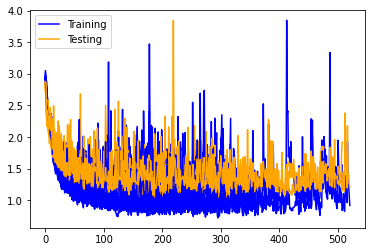

In [22]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

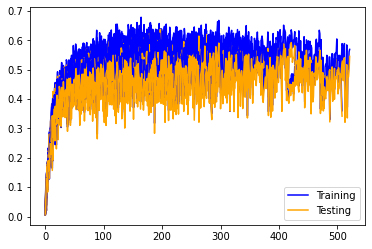

In [23]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

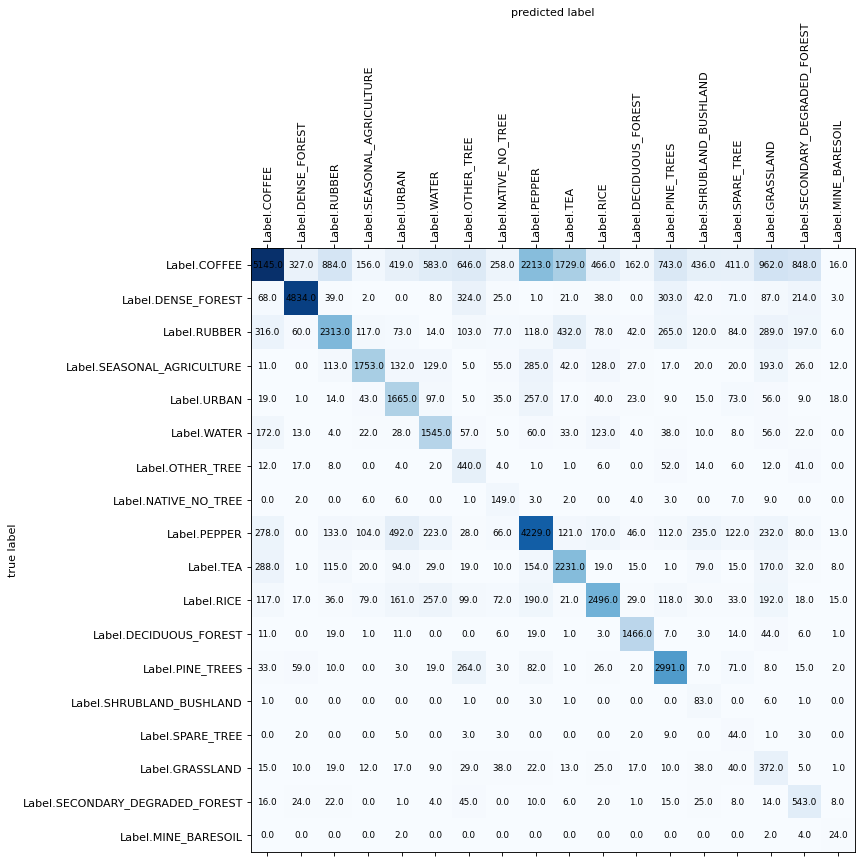

In [24]:
pl.figure(figsize=(12, 10), dpi=80)

plot_confusion_matrix(conf_matrix, labels)

In [25]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.79129499 0.9006894  0.62027353 0.75723542 0.53485384 0.52929085
 0.21266312 0.18486352 0.55302733 0.47752568 0.68950276 0.79673913
 0.6373322  0.07173725 0.04284323 0.13752311 0.2630814  0.18897638]
Mean precision:  0.4660807301922454

Recalls:  [0.31364301 0.79506579 0.49170918 0.59063342 0.69490818 0.70227273
 0.70967742 0.77604167 0.63270497 0.67606061 0.62713568 0.90942928
 0.83175751 0.86458333 0.61111111 0.53757225 0.72983871 0.75      ]
Mean recall:  0.6802302695864679

F-Score:  [0.44922728 0.8445881  0.54855923 0.66363808 0.60446542 0.60363352
 0.3272592  0.29859719 0.5901891  0.55970898 0.65684211 0.84936269
 0.72167933 0.13248204 0.08007279 0.21901678 0.38675214 0.30188679]
Mean f-score:  0.4909978216781316
